# Monte Carlo Simulation - Advanced

In this homework, we will work with the Lennard Jones equation added with cutoff distance and periodic boundary conditions.

$$ U(r) = 4 \epsilon \left[\left(\frac{\sigma}{r}\right)^{12} -\left(\frac{\sigma}{r}\right)^{6} \right] $$ 
Reduced units:
$$ U^*\left(r^*_{ij} \right) = 4 \left[\left(\frac{1}{r^*_{ij}}\right)^{12} -\left(\frac{1}{r^*_{ij}}\right)^{6} \right] $$ 

In [2]:
import math
import os
import matplotlib.pyplot as plt
import random

%matplotlib notebook

def calculate_LJ(r_ij):
    """
    The LJ interaction energy between two particles.
    
    Computes the pairwise Lennard Jones interaction energy based on the separation distance in reduced unites.
    
    Parameters
    ----------
    r_ij : float
        The distance between the particles in reduced units.
        
    Returns
    -------
    pairwise_energy : floa
        The pairwise Lennard Jones interaction energy in reduced units.
    
    """
    
    r6_term = math.pow(1/r_ij,6)
    r12_term = math.pow(r6_term,2)
    
    pairwise_energy = 4 * (r12_term - r6_term)
    ax.plot(r_ij,pairwise_energy,'ob')
    
    return pairwise_energy

######################################################################################################################

def calculate_distance(coord1,coord2,box_length=None):
    """
    Calculate the distance between two 3D coordinates.
    
    Parameters
    ----------
    coord1, coord2 : list
        The atomic coordinates [x, y, z]
    
    box_length : float, optional
        The box length. This function assumes box is a cube.
    
    Returns
    -------
    distance : float
        The distance between the two atoms.
    """
    
    distance = 0
    vector = [0,0,0]
    
    for i in range(3):
        vector[i] = coord1[i] -coord2[i]
        if box_length is None:
            pass
        else:
            if vector[i] > box_length/2:
                vector[i] -= box_length
            elif vector[i] < -box_length/2:
                vector[i] += box_length
        dim_dist = vector[i] ** 2
        distance += dim_dist
        
    distance = math.sqrt(distance)
    
    return distance

######################################################################################################################

def calculate_tail_correction(cutoff, box_length, num_atoms):
    """
    Calculate the tail correction.
    
    Parameters
    ----------
    cutoff : float
        The curoff distance.
        
    box_length : float
        The length of the cell.
       
    num_atoms : int
        Number of atoms in a given system.
       
    Returns
    -------
    tail_co_LJ : float
        A float number that shows the value of tail correction energy for the given system.
    """
    
    tail_co_LJ = 0
    
    coeff = 0
    
    r3 = math.pow(1/cutoff,3)
    r9 = math.pow(r3,3)
    
    coeff = 8 * math.pi * (num_atoms ** 2)/(3 * (box_length ** 3))

    tail_co_LJ = coeff * (r9/3 - r3)
    
    return tail_co_LJ

######################################################################################################################

def calculate_total_energy(coordinates, cutoff=3, box_length=None):
    """
    Calculate the total Lennard Jones energy of a system of particles.
    
    Parameters
    ----------
    coordinates : list
        Nested list containing particle coordinates.
        
    cutoff : float
        A criteria distance for intermolecular interaction truncation
    
    box_length : float, optional
        The box length. This function assumes box is a cube.
        
    Returns
    -------
    total_energy : float
        The total pairwise Lennard Jones energy of the system of particles.
    """
    
    total_energy = 0
    
    num_atoms = len(coordinates)
    
    for i in range(num_atoms):
        for j in range(i+1,num_atoms):
            
            # print(F'Comparing atom number {i} with atom number {j}')
            
            dist_ij = calculate_distance(coordinates[i], coordinates[j], box_length)
            
            if dist_ij < cutoff:
                interaction_energy = calculate_LJ(dist_ij)
                total_energy += interaction_energy
            
    return total_energy

######################################################################################################################

def read_xyz(filepath):
    """
    Reads coordinates from an xyz file.
    
    Parameters
    ----------
    filepath : str
       The path to the xyz file to be processed.
       
    Returns
    -------
    atomic_coordinates : list
        A two dimensional list containing atomic coordinates
    """
    
    with open(filepath) as f:
        box_length = float(f.readline().split()[0])
        num_atoms = float(f.readline())
        coordinates = f.readlines()
    
    atomic_coordinates = []
    
    for atom in coordinates:
        split_atoms = atom.split()
        
        float_coords = []
        
        # We split this way to get rid of the atom label.
        for coord in split_atoms[1:]:
            float_coords.append(float(coord))
            
        atomic_coordinates.append(float_coords)
    
    return atomic_coordinates, box_length

######################################################################################################################

def accept_or_reject(delta_e, beta):
    """
    Accept or reject based on change in energy and temperature.
    
    Parameters
    ----------
    delta_e : float
       The change of the system's energy.
       
    beta : float
        1 over the temperature.
       
    Returns
    -------
    accept : bool
        Accept the move or not.
    
    """
    if delta_e <= 0:
        accept = True
        
    else:
        rand_num = random.random()
        p_acc = math.exp(-beta * delta_e)
        
        if rand_num < p_acc:
            accept = True
        else:
            accept = False
            
    return accept

######################################################################################################################

def calculate_pair_energy(coordinates, i_particle, box_length, cutoff):
    """
    Calculate the interaction energy of the particles with its environment (all other particles in the system)
    
    Parameters
    ----------
    coordinates : list
        The coordinates for all the particles within the system.
        
    i_particle : int
        The particle index for which to calculate the energy.
        
    box_length : float
        The length of the simulation box.
        
    cutoff : float
        The simulation cutoff. Beyond this distance, interactions are not calculated.
        
    Returns
    -------
    e_total : float
        The pairwise interaction energy with the i_th particle with all other particles in the system.
        
    """
    e_total = 0
    
    num_atoms = len(coordinates)
    
    for i in range(num_atoms):
        
        # only consider the interactions with particles that is not the i_particle
        if i != i_particle:
            
            r_ij = calculate_distance(coordinates[i_particle], coordinates[i], box_length)
            
            if r_ij < cutoff:
            
                e_pair = calculate_LJ(r_ij)
                e_total += e_pair
    
    return e_total

######################################################################################################################

def initial_config(box_volume, num_particles):
    """
    Generate the initial configuration randomly by random()
    
    Parameters
    ----------
    box_volume : float
        The volume of the simulation box. 
        Here, the simulation box are regarded as a cubic box so that the box_length can be calculated directly.
        
    num_particles : int
        The number of particles within this system.
        
    Returns
    -------
    box_length : float
        The length of the cubic simulation box.
    
    coordinates : list
        The list that containing the coordinates of the atoms in the generated configuration.
    
    """
    
    # Assume that the simulation box is a cubic box and calculate the box_length
    box_length = box_volume ** (1/3)
    
    # Create a new empty list to store the generated coordinates.
    coordinates = []
    
    # Generate num_particles of coordinates
    for i in range(num_particles):
        
        x_rand = random.uniform(0, box_length)
        y_rand = random.uniform(0, box_length)
        z_rand = random.uniform(0, box_length) 
        
        coordinate = [x_rand, y_rand, z_rand]
        
        coordinates.append(coordinate)
    
    return box_length, coordinates

<IPython.core.display.Javascript object>


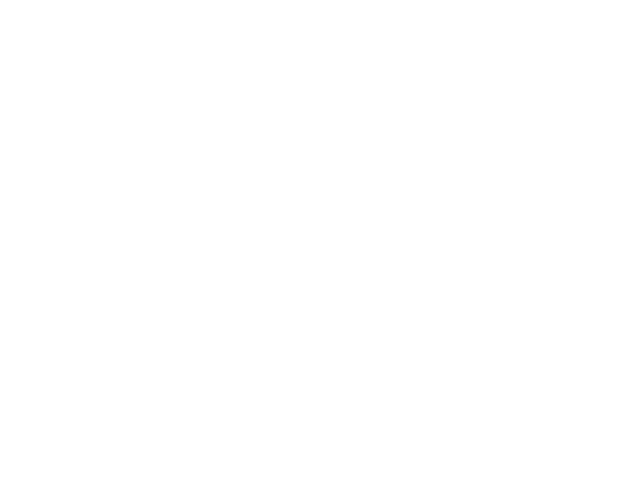

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
plt.ylim(-1.1,0.1)
for i in range(1, 51):
    r = i * 0.1
    calculate_LJ(r)

From this graph, it is obvious that when $r^*_{ij}$ > 3, the pairwise energy is almost 0 and the energy curve reaches a plateau. The general set of cutoff distance at 3$\sigma$ is reasonable.

In [4]:
assert calculate_LJ(1) == 0
assert calculate_LJ(math.pow(2,(1/6))) == -1

In [5]:
file_path = os.path.join('lj_sample_configurations','lj_sample_config_periodic1.txt')
coordinates, box_length = read_xyz(file_path)
calculate_total_energy(coordinates)

-3487.454232861954

In [6]:
calculate_total_energy(coordinates,box_length=10)

-4351.540194543858

In [7]:
assert abs(calculate_total_energy(coordinates,3, box_length=10) - (-4351.5)) < 0.1

## Flow of calculation

1. Generate an initial system state 'm'.
1. Choose an atom with uniform probability from state 'm'.
1. Propose a new state 'n' by translating the particle with a uniform random displacement in each direction.
1. Calculate the energy change for the particle.
1. Accept or reject the new state.

In [8]:
delta_energy = -1
beta = 1
assert accept_or_reject(delta_energy,beta) is True

In [9]:
delta_energy = 0
beta = 1
assert accept_or_reject(delta_energy,beta) is True

In [10]:
random.seed(0)
random.random()

0.8444218515250481

In [11]:
delta_energy = 1
beta = 1
p_acc = math.exp(-beta * delta_energy)
print(p_acc)

0.36787944117144233


In [12]:
random.seed(0)
delta_energy = 1
beta = 1
assert accept_or_reject(delta_energy,beta) is False

In [13]:
random.seed(1)
delta_energy = 1
beta = 1
assert accept_or_reject(delta_energy,beta) is True

In [14]:
# Unset random seed
random.seed()

In [15]:
coordinates = [[0, 0, 0], [0, math.pow(2, 1/6), 0], [0, 2*math.pow(2, 1/6), 0]]

assert calculate_pair_energy(coordinates, 1, 10, 3) == -2

assert calculate_pair_energy(coordinates, 0, 10, 3) == calculate_pair_energy(coordinates, 2, 10, 3)

# Monte Carlo Simulation loop

In [16]:
# Set simulation parameters
reduced_temperature = 0.9
num_steps = 500
max_displacement = 0.1
cutoff = 3

# Reporting information
freq = 100
steps = []
energies = []

# Calculate quantities
beta = 1 / reduced_temperature

# Read initial coordinates
file_path = os.path.join('lj_sample_configurations','lj_sample_config_periodic1.txt')
coordinates, box_length = read_xyz(file_path)
num_particles = len(coordinates)

# Calculate based on the inputs
total_energy = calculate_total_energy(coordinates, cutoff, box_length)
total_energy += calculate_tail_correction(cutoff, box_length, num_particles)

for step in range(num_steps):
    
    # 1. Randomly pick one particle in the num_particles particles.
    random_particle = random.randrange(0,num_particles)
    
    # 2. Calculate the interaction energy of the selected particles with the system and store this value.
    current_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    
    # 3. Generate a random displacement in x, y, z directions with range (-max_displacement, max_displacement).
    x_rand = random.uniform(-max_displacement, max_displacement)
    y_rand = random.uniform(-max_displacement, max_displacement)
    z_rand = random.uniform(-max_displacement, max_displacement)
    
    # 4. Modify the coordinate of the selected particle by generated displacement.
    coordinates[random_particle][0] += x_rand
    coordinates[random_particle][1] += y_rand
    coordinates[random_particle][2] += z_rand
    
    # 5. Calculate the new interaction energy of the new particle and store this value.
    proposed_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    
    # 6. Calculate energy change and decide if this move is accepted.
    delta_energy = proposed_energy - current_energy
    
    accept = accept_or_reject(delta_energy, beta)
    
    # 7. If accepted, keep movement. Else, revert to the old position.
    if accept == True:
        total_energy += delta_energy
    else:
        # if rejected, roll back to the origin coordinates of the selected particle.
        coordinates[random_particle][0] -= x_rand
        coordinates[random_particle][1] -= y_rand
        coordinates[random_particle][2] -= z_rand
    
    # 8. Print the energy and store the coordinates at certain intervals.
    if step % freq == 0:
        print(step, total_energy/num_particles)
        steps.append(step)
        energies.append(total_energy/num_particles)

0 -5.687536347860019
100 -5.6800021313626345
200 -5.692347688033792
300 -5.680154893940043
400 -5.677301490915275


<IPython.core.display.Javascript object>


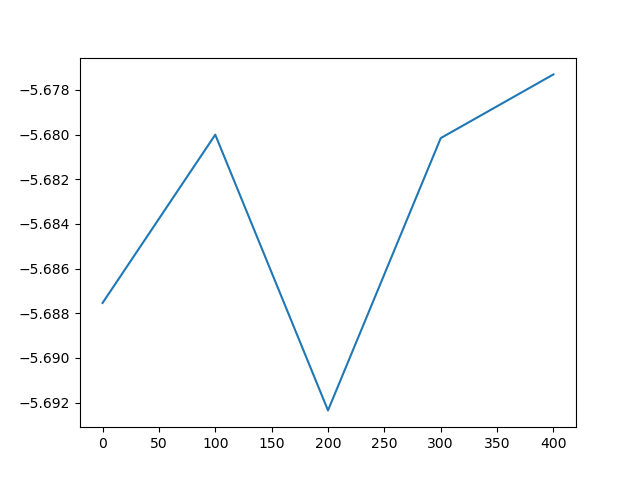

In [17]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(steps, energies)

## Generate initial configuration randomly

In [18]:
def initial_config(box_volume, num_particles):
    """
    Generate the initial configuration randomly by random()
    
    Parameters
    ----------
    box_volume : float
        The volume of the simulation box. 
        Here, the simulation box are regarded as a cubic box so that the box_length can be calculated directly.
        
    num_particles : int
        The number of particles within this system.
        
    Returns
    -------
    box_length : float
        The length of the cubic simulation box.
    
    coordinates : list
        The list that containing the coordinates of the atoms in the generated configuration.
    
    """
    
    # Assume that the simulation box is a cubic box and calculate the box_length
    box_length = box_volume ** (1/3)
    
    # Create a new empty list to store the generated coordinates.
    coordinates = []
    
    # Generate num_particles of coordinates
    for i in range(num_particles):
        
        x_rand = random.uniform(0, box_length)
        y_rand = random.uniform(0, box_length)
        z_rand = random.uniform(0, box_length) 
        
        coordinate = [x_rand, y_rand, z_rand]
        
        coordinates.append(coordinate)
    
    return box_length, coordinates

In [19]:
# sanity check for def initial_config

box_vol = 1000
num_atoms = 5

box_length, coordiantes = initial_config(box_vol, num_atoms)

print(box_length)
print('\n')
print(coordiantes)

9.999999999999998


[[9.315460751530292, 6.071094506554592, 8.15742517211877], [8.81590059270481, 8.156742827498276, 7.70268646348671], [0.2009872500562526, 5.066423307467187, 7.07641551976499], [6.054905747180621, 7.7972834433299925, 3.493622814189625], [9.313065717852886, 8.687649879032831, 7.174590038361152]]
